In [370]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import OrdinalEncoder
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from scipy.stats import boxcox

from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae

# suppress warnings about "value is trying to be set on a copy of a slice from a DataFrame"
pd.options.mode.chained_assignment = None 

In [371]:
life_df = pd.read_csv("Data/life_expectancy.csv")
life_df

,country,country_code,region,year,life_expect,life_exp60,adult_mortality,infant_mort,age1-4mort,alcohol,...,che_gdp,une_pop,une_infant,une_life,une_hiv,une_gni,une_poverty,une_edu_spend,une_literacy,une_school
0,Angola,AGO,Africa,2000,47.33730,14.73400,383.5583,0.137985,0.025695,1.47439,...,1.90860,16395.473,122.2,46.522,1.0,2530.0,32.3,2.60753,NaN,NaN
1,Angola,AGO,Africa,2001,48.19789,14.95963,372.3876,0.133675,0.024500,1.94025,...,4.48352,16945.753,118.9,47.059,1.1,2630.0,NaN,NaN,67.40542,NaN
2,Angola,AGO,Africa,2002,49.42569,15.20010,354.5147,0.128320,0.023260,2.07512,...,3.32946,17519.417,115.1,47.702,1.2,3180.0,NaN,NaN,NaN,NaN
3,Angola,AGO,Africa,2003,50.50266,15.39144,343.2169,0.122040,0.021925,2.20275,...,3.54797,18121.479,110.8,48.440,1.3,3260.0,NaN,NaN,NaN,NaN
4,Angola,AGO,Africa,2004,51.52863,15.56860,333.8711,0.115700,0.020545,2.41274,...,3.96720,18758.145,106.2,49.263,1.3,3560.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3106,Lao People's Democratic Republic,LAO,Western Pacific,2012,64.49448,16.57977,209.2666,0.055840,0.004845,6.29833,...,2.07638,6444.530,47.5,65.267,0.3,4570.0,22.7,1.82147,NaN,NaN
3107,Lao People's Democratic Republic,LAO,Western Pacific,2013,64.79716,16.64219,205.1459,0.055350,0.004600,6.42186,...,2.39985,6541.304,45.6,65.717,0.3,4980.0,NaN,3.23381,NaN,NaN
3108,Lao People's Democratic Republic,LAO,Western Pacific,2014,65.10757,16.70787,200.8204,0.054585,0.004405,6.64447,...,2.29846,6639.756,43.7,66.144,0.3,5440.0,NaN,2.93781,NaN,NaN
3109,Lao People's Democratic Republic,LAO,Western Pacific,2015,65.45008,16.77074,196.6613,0.053465,0.004160,6.83826,...,2.45366,6741.164,42.0,66.546,0.3,5810.0,NaN,NaN,84.66104,NaN


In [372]:
life_df.isna().sum()

country               0
country_code          0
region                0
year                  0
life_expect           0
life_exp60            0
adult_mortality       0
infant_mort           0
age1-4mort            0
alcohol              50
bmi                  34
age5-19thinness      34
age5-19obesity       34
hepatitis           569
measles              19
polio                19
diphtheria           19
basic_water          32
doctors            1331
hospitals          2981
gni_capita          682
gghe-d              100
che_gdp             117
une_pop              37
une_infant            0
une_life              0
une_hiv             741
une_gni             117
une_poverty        2198
une_edu_spend      1286
une_literacy       2540
une_school         2306
dtype: int64

## Functions

Defining functions which will be used later to build a data cleaning pipeline. 

In [373]:
def headers_to_lowercase (df):
    df.columns = df.columns.str.lower()
    return df


def text_to_lowercase (df):
    df = df.applymap(lambda s: s.lower() if type(s) == str else s)
    return df   


def drop_columns (df, list_of_columns_to_drop):    
    df.drop(columns = list_of_columns_to_drop, inplace=True)
    return df


def drop_rows (df, country_drop_list):
    df = df[~df['country'].isin(country_drop_list)]
    return df


def fill_na_in_population_with_values_from_dict (df):
    
    singapore_pop_dict = {2000:4028.871 , 2001:4077.145 , 2002:4104.419 , 2003:4129.225 , 2004: 4177.213 , 2005: 4265.687 , 2006:4402.331 , 2007:4578.630 , 2008:4775.804 , 2009:4966.614 , 2010:5131.172 , 2011:5263.636, 2012:5369.476, 2013:5453.737, 2014:5525.626, 2015:5592.152, 2016:5653.634}
    ukraine_pop_dict = {2014:45111.532, 2015:44921.639, 2016: 44713.702}
    brazil_pop_dict = {2000:174790.340, 2006: 188167.356, 2010:195713.635}
    
    df['une_pop'][df['country']=="singapore"] = df['une_pop'][df['country']=="singapore"].fillna(df['year'].map(singapore_pop_dict))
    df['une_pop'][df['country']=="brazil"] = df['une_pop'][df['country']=="brazil"].fillna(df['year'].map(brazil_pop_dict))
    df['une_pop'][df['country']=="ukraine"] = df['une_pop'][df['country']=="ukraine"].fillna(df['year'].map(ukraine_pop_dict))
    
    return df


def change_col_names (df, column_name_dict):
    df.rename(columns=column_name_dict, inplace= True)
    return df


def replace_nans_with_country_mean (df, list_of_categories):
    for i in list_of_categories:
        df[i] = df[i].fillna(df.groupby('country')[i].transform('mean'))
    return df


def round_floats (df):
    df = df.applymap(lambda s: np.round(s,5) if type(s) == float else s)
    return df 

## Variables for data cleaning
<br>
After exploring our data we decided which columns and rows should be dropped. The main reason for dropping columns and rows was a big amount of missing values which could not easily be replaced. 
<br><br>
For filling NaNs we used the mean of the category and the corresponding country.

In [374]:
list_of_columns_to_drop = ['country_code', 'hospitals','gni_capita','une_hiv', 'une_poverty', 'une_edu_spend', 'une_literacy','une_school', 'une_infant', 'une_life','hepatitis','life_exp60','infant_mort','diphtheria','measles','bmi','adult_mortality']
country_drop_list = ['somalia','sudan','montenegro','south sudan',"democratic people's republic of korea", 'albania', 'bosnia and herzegovina','syrian arab republic','cuba','djibouti']
column_name_dict = {'life_expect':'life_expectancy','life_exp60':'life_expectancy_at_60','infant_mort':'infant_mortality','age1-4mort':'age_1-4_mortality', 'age5-19thinness':'age_5-19_thinness', 'age5-19obesity':'age_5-19_obesity','polio':'polio_vacc', 'basic_water':'basic_water_access', 'doctors':'doctors_per_10000', 'une_pop':'population', 'une_gni':'gni'}
list_of_categories = ['alcohol','doctors_per_10000','gni','polio_vacc','basic_water_access','gghe-d','che_gdp']

## Data cleaning pipeline

In [375]:
life_df = (life_df
.pipe(headers_to_lowercase)
.pipe(text_to_lowercase)
.pipe(drop_columns, list_of_columns_to_drop)
.pipe(drop_rows, country_drop_list)
.pipe(fill_na_in_population_with_values_from_dict)
.pipe(change_col_names, column_name_dict)
.pipe(replace_nans_with_country_mean, list_of_categories)
.pipe(round_floats)
)

In [376]:
new_df.isna().sum()

country               0
region                0
year                  0
life_expectancy       0
age_1-4_mortality     0
alcohol               0
age_5-19_thinness     0
age_5-19_obesity      0
polio_vacc            0
basic_water_access    0
doctors_per_10000     0
gghe-d                0
che_gdp               0
population            0
gni                   0
dtype: int64

In [377]:
#life_df.to_csv("Data/cleaned_life_expectancy_df.csv", index=False)

## Prep for data for modeling 

After multiple trials we decided that we will run the model on the numerical values only - using the categorical values caused overfitting of the model. 

### 1. Getting numerical variables

In [378]:
life_num = life_df._get_numeric_data()
life_num = life_num.drop(columns='year')
life_num

,life_expectancy,age_1-4_mortality,alcohol,age_5-19_thinness,age_5-19_obesity,polio_vacc,basic_water_access,doctors_per_10000,gghe-d,che_gdp,population,gni
0,47.33730,0.02570,1.47439,11.0,0.5,21.0,41.14431,0.96700,1.11099,1.90860,16395.473,2530.0
1,48.19789,0.02450,1.94025,10.9,0.5,28.0,42.25467,0.96700,2.04631,4.48352,16945.753,2630.0
2,49.42569,0.02326,2.07512,10.7,0.6,22.0,43.37680,0.96700,1.30863,3.32946,17519.417,3180.0
3,50.50266,0.02192,2.20275,10.5,0.7,21.0,44.36387,0.96700,1.46560,3.54797,18121.479,3260.0
4,51.52863,0.02054,2.41274,10.3,0.8,18.0,45.35134,0.62100,1.68663,3.96720,18758.145,3560.0
...,...,...,...,...,...,...,...,...,...,...,...,...
3106,64.49448,0.00485,6.29833,9.2,3.1,78.0,72.07056,1.80000,0.43670,2.07638,6444.530,4570.0
3107,64.79716,0.00460,6.42186,9.1,3.5,86.0,74.05544,4.49300,0.71266,2.39985,6541.304,4980.0
3108,65.10757,0.00440,6.64447,9.0,3.8,88.0,76.02924,4.94900,0.68373,2.29846,6639.756,5440.0
3109,65.45008,0.00416,6.83826,8.9,4.2,80.0,77.99142,3.77612,0.86391,2.45366,6741.164,5810.0


### 2. Plotting a heatmap and scatter plots to look for correlations

We already decided beforehand after multiple trial and errors which columns should be deleted for sure, but here we're checking one more time if there is anything that might still cause overfitting of the model. 

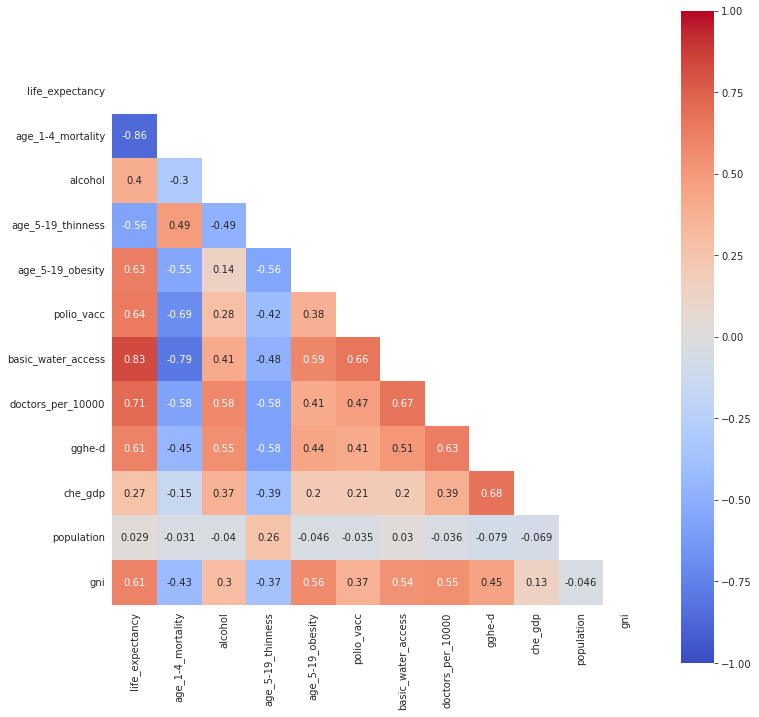

In [379]:
corr = life_num.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(12, 12))
    ax = sns.heatmap(corr, mask=mask,cmap='coolwarm', vmin=-1,vmax=1,annot=True, square=True)

In [380]:
#sns.pairplot(life_num)

array([[<AxesSubplot:title={'center':'life_expectancy'}>,
        <AxesSubplot:title={'center':'age_1-4_mortality'}>,
        <AxesSubplot:title={'center':'alcohol'}>],
       [<AxesSubplot:title={'center':'age_5-19_thinness'}>,
        <AxesSubplot:title={'center':'age_5-19_obesity'}>,
        <AxesSubplot:title={'center':'polio_vacc'}>],
       [<AxesSubplot:title={'center':'basic_water_access'}>,
        <AxesSubplot:title={'center':'doctors_per_10000'}>,
        <AxesSubplot:title={'center':'gghe-d'}>],
       [<AxesSubplot:title={'center':'che_gdp'}>,
        <AxesSubplot:title={'center':'population'}>,
        <AxesSubplot:title={'center':'gni'}>]], dtype=object)

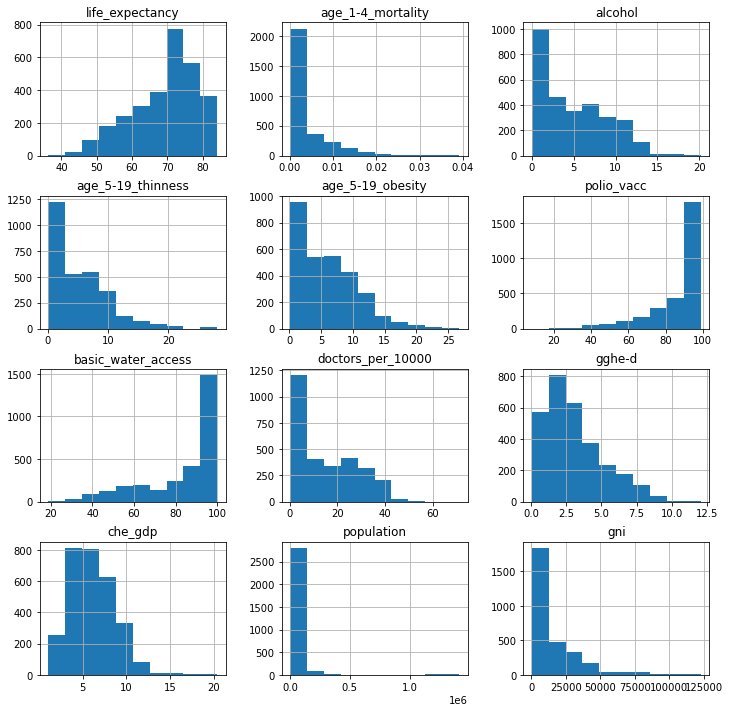

In [381]:
life_num.hist(figsize=[12,12])

## Data transformation

### 1. X / y split
<br>
Our target variable is the life expectancy column.

In [382]:
X = life_num.drop('life_expectancy', axis=1)

y = life_num['life_expectancy']

### 2. Train / Test split
<br>
We are splitting the data randomly in ratio 70/30.

In [383]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.30,random_state=100)

### 3. Scaling the data
<br>
Since we are only using the numerical data we are going to use the Standard Scaler to standardize all columns. 

In [384]:
#TRAIN

std_scaler=StandardScaler().fit(X_train)   

X_train_scaled=std_scaler.transform(X_train)

#TEST

X_test_scaled=std_scaler.transform(X_test)

## Regression

### 1. Model fitting

In [385]:
model=LinearRegression()    
model.fit(X_train_scaled, y_train)

LinearRegression()

In [386]:
coef = list(model.coef_)
print('Our model coefficients are: ','\n', (', '.join(map(str, coef))),'\n','\n',' Our model intercept is: ', model.intercept_)

Our model coefficients are:  
 -4.665109887299291, -0.4172167582872511, -0.4362864057888645, 0.2692910720743429, -0.23335708043608605, 1.706128365222388, 1.0322453097550397, 1.3873913137658107, -0.17572099642565142, 0.42007988525162054, 1.373803000607634 
 
  Our model intercept is:  69.29048344023323


### 2. Making prediction on the test set

In [387]:
y_pred=model.predict(X_test_scaled)

result = pd.DataFrame({"y_test":y_test,"y_pred":y_pred})
result

,y_test,y_pred
1818,82.36343,82.149578
134,62.06905,60.249526
1700,68.54817,65.755780
659,64.58259,66.212893
2977,63.46142,68.061577
...,...,...
818,73.42290,72.898061
648,59.28408,62.359483
2754,79.64923,77.011157
792,71.82126,69.042407


### 3. Plotting
<br>
On the visualizations below we plotted the predicted vs. real values as well as the distribution of the residuals.

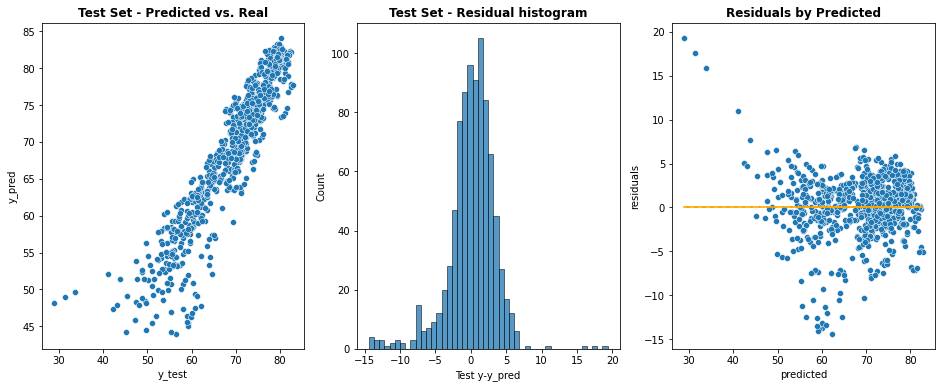

In [388]:
fig1, ax1 = plt.subplots(1,3, figsize=(16,6))

sns.scatterplot(x=y_pred, y=y_test, ax=ax1[0])
ax1[0].set_xlabel("y_test")
ax1[0].set_ylabel("y_pred")
ax1[0].set_title('Test Set - Predicted vs. Real', fontweight='bold')

sns.histplot(x = y_test-y_pred, ax = ax1[1])
ax1[1].set_xlabel("Test y-y_pred")
ax1[1].set_title('Test Set - Residual histogram', fontweight='bold')

sns.scatterplot(x = y_pred,y = y_test - y_pred, ax=ax1[2])
ax1[2].set_xlabel("predicted")
ax1[2].set_ylabel("residuals")
ax1[2].set_title('Residuals by Predicted', fontweight='bold')
ax1[2].plot(y_pred,np.zeros(len(y_pred)),linestyle='dashed', color='orange')

### 4. Model validation

In [393]:
MSE = mse(y_test,y_pred) #average squared difference between observed and predicted values.
MAE = mae(y_test,y_pred) #measures the average magnitude of the errors in a set of predictions, without considering their direction.
RMSE = np.sqrt(MSE) #square root of the mean squared error.

R2_test = model.score(X_test_scaled, y_test)
Adj_R2_test = 1 - (1-R2)*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)

R2_train = model.score(X_train_scaled, y_train)
Adj_R2_train = 1 - (1-R2)*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)

print("The Mean Squared Error is: ", MSE) 
print("The Mean Absolute Error is: ", MAE)
print("The Root Mean Squared Error is: ", RMSE)
print('\n')
print("The R2 for the test set is: ", R2_test)
print("The Adjusted R2 for the test set is: ", Adj_R2_test)
print('\n')
print("The R2 for the train set is: ", R2_train)
print("The Adjusted R2 for the train set is: ", Adj_R2_train)

The Mean Squared Error is:  11.515614585181224
The Mean Absolute Error is:  2.403960918715084
The Root Mean Squared Error is:  3.3934664555850884


The R2 for the test set is:  0.8615577613640064
The Adjusted R2 for the test set is:  0.8696115265913072


The R2 for the train set is:  0.8712376866905086
The Adjusted R2 for the train set is:  0.8696115265913072
